# 1. **Setup**

In [1]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 3.4 MB 9.8 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
     |████████████████████████████████| 596 kB 74.9 MB/s 
     |████████████████████████████████| 895 kB 59.6 MB/s 
     |████████████████████████████████| 3.3 MB 62.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 8.6 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. **Imports**

In [14]:
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
from transformers import AdamW, XLNetTokenizer, XLNetModel, TFXLNetModel, XLNetLMHeadModel, XLNetConfig, XLNetForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm, trange

import tensorflow as tf
import pandas as pd
import re
import copy
import numpy as np
import os
import torch
import time
import datetime

import seaborn as sns
import matplotlib
matplotlib.style.use('seaborn-darkgrid')
import matplotlib.pyplot as plt

PATH = "/content/drive/My Drive/NN-NLP/"

# 3. **Hyperparameters**

In [4]:
PRETRAINED_MODEL_NAME = "xlnet-base-cased"

MAX_LENGTH = 128
BATCH_SIZE = 32
TRAIN_EPOCHS = 4
LEARNING_RATE = 1e-5
ADAM_EPSILON = 1e-8
WEIGHT_DECAY = 0.01

# 4. **Upload Dataset**

In [38]:
df = pd.read_csv("/content/drive/My Drive/NN-NLP/IMDB Dataset.csv")

In [39]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# 5. **Preprocessing Reviews**

In [40]:
preprocessed_df = copy.deepcopy(df)
preprocessed_df['review'] = preprocessed_df['review'].apply(lambda review: re.sub('<[^<]+?>', '', str(review)))
preprocessed_df['sentiment'] = preprocessed_df['sentiment'].replace('positive', 1)
preprocessed_df['sentiment'] = preprocessed_df['sentiment'].replace('negative', 0)

In [41]:
preprocessed_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [42]:
train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(preprocessed_df['review'].to_numpy(),
                                                                                  preprocessed_df['sentiment'].to_numpy(),
                                                                                  test_size=0.5)

indexes_validation = np.random.choice(test_reviews.shape[0], int(test_reviews.shape[0] * 0.2), replace=False)
validation_reviews = test_reviews[indexes_validation]
validation_sentiments = test_sentiments[indexes_validation]

In [43]:
print(train_reviews.shape)
print(validation_reviews.shape)
print(test_reviews.shape)

(25000,)
(5000,)
(25000,)


In [44]:
train_df = pd.DataFrame(np.array([train_reviews, train_sentiments]).T, columns=['review', 'sentiment'])
validation_df = pd.DataFrame(np.array([validation_reviews, validation_sentiments]).T, columns=['review', 'sentiment'])
test_df = pd.DataFrame(np.array([test_reviews, test_sentiments]).T, columns=['review', 'sentiment'])

In [45]:
train_df

,review,sentiment
0,"I walked into the movie theater, with no expec...",1
1,This movie made by the NFBC was made in honor ...,1
2,This may just be the worst movie of all time. ...,0
3,"This movie was so great! I am a teenager, and ...",1
4,Many of the criticisms on this thread seem to ...,1
...,...,...
24995,SAKURA KILLERS (1+ outta 5 stars) Maybe in 198...,0
24996,"This show was great, it wasn't just for kids w...",1
24997,"A horribly pointless and, worse, boring film. ...",0
24998,"The Legend of Zu, as I saw it, was a very inte...",1


In [46]:
def convert_data_to_input_examples(data_df, text_col, label_col):
    data_input_examples = data_df.apply(lambda data_review: InputExample(guid='', text_a=data_review[text_col],
                                                                         text_b=None, label=data_review[label_col]), axis=1)

    return data_input_examples

In [47]:
train_input_examples = convert_data_to_input_examples(data_df=train_df, text_col='review', label_col='sentiment')
validation_input_examples = convert_data_to_input_examples(data_df=validation_df, text_col='review', label_col='sentiment')
test_input_examples = convert_data_to_input_examples(data_df=test_df, text_col='review', label_col='sentiment')

In [48]:
train_input_examples

0        InputExample(guid='', text_a='I walked into th...
1        InputExample(guid='', text_a="This movie made ...
2        InputExample(guid='', text_a='This may just be...
3        InputExample(guid='', text_a='This movie was s...
4        InputExample(guid='', text_a='Many of the crit...
                               ...                        
24995    InputExample(guid='', text_a='SAKURA KILLERS (...
24996    InputExample(guid='', text_a="This show was gr...
24997    InputExample(guid='', text_a="A horribly point...
24998    InputExample(guid='', text_a="The Legend of Zu...
24999    InputExample(guid='', text_a='Brilliant work. ...
Length: 25000, dtype: object

# 6. **Tokenization & Input Formatting**

In [49]:
tokenizer = XLNetTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [50]:
def tokenize_input_example(input_example, tokenizer, max_length):
    input_ids = tokenizer(input_example.text_a, 
                          truncation=True,  
                          max_length=max_length).get("input_ids")
    # append special token "<s>" and </s> to end of sentence
    input_ids = tokenizer.build_inputs_with_special_tokens(input_ids) 
    # pad sequences
    input_ids = pad_sequences([input_ids], maxlen=max_length, dtype="long", truncating="post", padding="post")[0]

    return input_ids

In [51]:
def create_attention_mask(input_ids):
    # Create a mask of 1s for each token followed by 0s for padding
    attention_mask = [float(i>0) for i in input_ids]
  
    return attention_mask

In [52]:
def convert_input_examples_to_tf_dataset(input_examples, tokenizer, max_length=MAX_LENGTH):
    inputs_ids = []
    attention_masks = []
    labels = []

    for input_example in input_examples:
        input_ids = tokenize_input_example(input_example, tokenizer, max_length)

        attention_mask = create_attention_mask(input_ids)

        inputs_ids.append(input_ids)
        attention_masks.append(attention_mask)
        labels.append(input_example.label)

    inputs_ids_pt = torch.from_numpy(np.array(inputs_ids))
    attention_masks_pt = torch.tensor(attention_masks)
    labels_pt = torch.tensor(labels)

    return TensorDataset(inputs_ids_pt, attention_masks_pt, labels_pt)

In [53]:
train_tf_dataset = convert_input_examples_to_tf_dataset(train_input_examples.to_numpy(), tokenizer)
validation_tf_dataset = convert_input_examples_to_tf_dataset(validation_input_examples.to_numpy(), tokenizer)
test_tf_dataset = convert_input_examples_to_tf_dataset(test_input_examples.to_numpy(), tokenizer)

In [54]:
print(train_tf_dataset)
print(validation_tf_dataset)
print(test_tf_dataset)

In [55]:
# Create the DataLoaders for datasets
train_dataloader = DataLoader(train_tf_dataset,  # The training samples
                              sampler=RandomSampler(train_tf_dataset), # Select batches randomly
                              batch_size=BATCH_SIZE) # Trains with this batch size

validation_dataloader = DataLoader(validation_tf_dataset, # The validation samples
                                   sampler=SequentialSampler(validation_tf_dataset), # Pull out batches sequentially
                                    batch_size=BATCH_SIZE) # Evaluate with this batch size

test_dataloader = DataLoader(test_tf_dataset, # The test samples
                             sampler=SequentialSampler(test_tf_dataset), # Pull out batches sequentially
                             batch_size=BATCH_SIZE) # Evaluate with this batch size
        

In [56]:
print(train_dataloader)
print(validation_dataloader)
print(test_dataloader)

# 7. **XLNet**

In [7]:
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [8]:
model = XLNetForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=2)

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [9]:
model.cuda()

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

# 8. **Train XLNet Model**

In [60]:
torch.cuda.empty_cache()

In [61]:
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [62]:
# function to save and load the model form a specific epoch
def save_model(model, save_path, epoch, lowest_eval_loss, best_eval_accuracy, training_stats):
  model_to_save = model.module if hasattr(model, 'module') else model

  checkpoint = {'state_dict': model_to_save.state_dict(),
                'best_eval_accuracy': best_eval_accuracy,
                'lowest_eval_loss': lowest_eval_loss,
                'training_stats': training_stats,
                'epochs': epoch}

  torch.save(checkpoint, save_path)
  print("\nSaving model at epoch {} with validation loss {} and validation accuracy {}".format(epoch, 
                                                                                               str(lowest_eval_loss), 
                                                                                               str(best_eval_accuracy)))
  

In [63]:
def train(model, num_epochs, optimizer, train_dataloader, validation_dataloader, model_save_path):

    best_eval_accuracy = None
    lowest_eval_loss = None

    training_stats = []  # We'll store a number of quantities such as training and validation loss, validation accuracy, and timings

    total_t0 = time.time()  # Measure the total training time for the whole run

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

##### Training
    for epoch in range(num_epochs):
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))
        print('Training...\n')

        t0 = time.time()  # Measure how long the training epoch takes
    
        model.train()  # Set our model to training mode (as opposed to evaluation mode)

        # Tracking variables
        train_loss = 0
        num_train_steps = 0
        train_logits = []
        train_label_ids = []

        # Train the data for one epoch
        for step, batch in enumerate(train_dataloader):

            if step % 40 == 0 and step > 0:  # Progress update every 40 training steps
                elapsed = format_time(time.time() - t0)  # Calculate elapsed time in minutes
                print('  Train Step {:>5,}  of  {:>5,}.    Elapsed time steps: {:}.'.format(step, len(train_dataloader), elapsed))  # Report progress
            
            batch = tuple(t.to(device) for t in batch)  # Add batch to GPU
            
            b_input_ids, b_input_mask, b_labels = batch  # Unpack the inputs from our dataloader
          
            optimizer.zero_grad()  # Clear out the gradients (by default they accumulate)
           
            outputs = model(input_ids=b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)  # Forward pass

            loss = outputs[0] 
            logits = outputs[1]
            
            loss.backward()  # Backward pass
            
            optimizer.step()  # Update parameters and take a step using the computed gradient

            train_loss += loss.item()  # Update tracking variables
            num_train_steps += 1

            train_logits.append(logits.detach().cpu().numpy())
            train_label_ids.append(b_labels.to('cpu').numpy())

        epoch_train_loss = train_loss / num_train_steps  

        train_logits = np.vstack(train_logits) 
        train_label_ids = np.hstack(train_label_ids)
        predictions_train_logits = np.argmax(train_logits, axis=1).flatten()
        epoch_train_accuracy = np.sum(predictions_train_logits  == train_label_ids) / train_label_ids.shape[0]

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("\n  Epoch Train Loss: {0:.5f}".format(epoch_train_loss))
        print("  Epoch Train Accuracy: {0:.5f}".format(epoch_train_accuracy))
        print("  Time Elapsed Epcoh: {:}".format(training_time))
      
######### Validation
        print("\nRunning Validation...\n")

        t0 = time.time()
        
        model.eval() # Put model in evaluation mode to evaluate loss on the validation set

        # Tracking variables 
        eval_loss = 0
        num_eval_steps = 0
        eval_logits = []
        eval_label_ids = []

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            batch = tuple(t.to(device) for t in batch) # Add batch to GPU
            
            b_input_ids, b_input_mask, b_labels = batch  # Unpack the inputs from our dataloader
            
            with torch.no_grad():  # Telling the model not to compute or store gradient, saving memory and speeding up validation
                
                outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels) # Forward pass, calculate validation loss

                loss = outputs[0] 
                logits = outputs[1]
            
            eval_loss += loss.item()  # Update tracking variables
            num_eval_steps += 1

            eval_logits.append(logits.detach().cpu().numpy())
            eval_label_ids.append(b_labels.to('cpu').numpy())

        epoch_eval_loss = eval_loss / num_eval_steps  

        eval_logits = np.vstack(eval_logits) 
        eval_label_ids = np.hstack(eval_label_ids)
        predictions_eval_logits = np.argmax(eval_logits, axis=1).flatten()
        epoch_eval_accuracy = np.sum(predictions_eval_logits  == eval_label_ids) / eval_label_ids.shape[0]
        
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        
        print("  Epoch Validation Loss: {0:.5f}".format(epoch_eval_loss))
        print("  Epoch Validation Accuracy: {0:.5f}".format(epoch_eval_accuracy))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch
        training_stats.append({'epoch': epoch,
                               'Train Loss': epoch_train_loss,
                               'Train Accuracy': epoch_train_accuracy,   
                               'Training Time': training_time,
                               'Validation Loss': epoch_eval_loss,
                               'Validation Accuracy': epoch_eval_accuracy, 
                               'Validation Time': validation_time})

        # Save best model based on max accuracy for validation
        if best_eval_accuracy == None:
          best_eval_accuracy = epoch_eval_accuracy
          lowest_eval_loss = epoch_eval_loss

          save_model(model=model, 
                     save_path=model_save_path, 
                     epoch=epoch, 
                     lowest_eval_loss=lowest_eval_loss, 
                     best_eval_accuracy=best_eval_accuracy, 
                     training_stats=training_stats)
        else:
          if epoch_eval_accuracy > best_eval_accuracy:
            best_eval_accuracy = epoch_eval_accuracy
            lowest_eval_loss = epoch_eval_loss
          
            save_model(model=model, 
                     save_path=model_save_path, 
                     epoch=epoch, 
                     lowest_eval_loss=lowest_eval_loss, 
                     best_eval_accuracy=best_eval_accuracy, 
                     training_stats=training_stats)
      
    print("\nTraining complete!")
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    return model, training_stats

In [64]:
optimizer = AdamW(model.parameters(), 
                  lr = LEARNING_RATE,
                  eps = ADAM_EPSILON,
                  weight_decay=WEIGHT_DECAY)

In [65]:
model_save_path = os.path.join(PATH, "xlnet.bin")

model, training_stats = train(model=model, 
                              num_epochs=TRAIN_EPOCHS, 
                              optimizer=optimizer, 
                              train_dataloader=train_dataloader, 
                              validation_dataloader=validation_dataloader, 
                              model_save_path=model_save_path)

======== Epoch 1 / 4 ========
Training...

  Train Step    40  of    782.    Elapsed time steps: 0:01:06.
  Train Step    80  of    782.    Elapsed time steps: 0:02:13.
  Train Step   120  of    782.    Elapsed time steps: 0:03:19.
  Train Step   160  of    782.    Elapsed time steps: 0:04:25.
  Train Step   200  of    782.    Elapsed time steps: 0:05:31.
  Train Step   240  of    782.    Elapsed time steps: 0:06:36.
  Train Step   280  of    782.    Elapsed time steps: 0:07:42.
  Train Step   320  of    782.    Elapsed time steps: 0:08:48.
  Train Step   360  of    782.    Elapsed time steps: 0:09:54.
  Train Step   400  of    782.    Elapsed time steps: 0:11:00.
  Train Step   440  of    782.    Elapsed time steps: 0:12:06.
  Train Step   480  of    782.    Elapsed time steps: 0:13:12.
  Train Step   520  of    782.    Elapsed time steps: 0:14:18.
  Train Step   560  of    782.    Elapsed time steps: 0:15:23.
  Train Step   600  of    782.    Elapsed time steps: 0:16:29.
  Train Step

# 9. **Evaluate XLNet Model**

In [5]:
def load_model(save_path):

    if tf.test.gpu_device_name() == '/device:GPU:0':
        checkpoint = torch.load(save_path) 
    else:
        checkpoint = torch.load(save_path, map_location=torch.device('cpu'))

    model_state_dict = checkpoint['state_dict']
    model.load_state_dict(model_state_dict)

    best_eval_accuracy = checkpoint['best_eval_accuracy']
    lowest_eval_loss = checkpoint['lowest_eval_loss']
    training_stats = checkpoint['training_stats']
    epoch = checkpoint['epochs']
    
    return model, training_stats

In [10]:
model_save_path = os.path.join(PATH, "xlnet.bin")

#model = load_model(save_path=model_save_path)
model, training_stats = load_model(save_path=model_save_path)

In [68]:
def evaluate_model(model, test_dataloader):

    print("Testing...\n")

    start = time.time()
        
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()  # Put model in evaluation mode

    # Tracking variables 
    test_loss = 0
    num_test_steps = 0
    test_logits = []
    test_label_ids = []

    # Evaluate data
    for batch in test_dataloader:

        batch = tuple(t.to(device) for t in batch) # Add batch to GPU
            
        b_input_ids, b_input_mask, b_labels = batch  # Unpack the inputs from our dataloader
            
        with torch.no_grad():  # Telling the model not to compute or store gradient, saving memory and speeding up testing
                
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels) # Forward pass, calculate test loss

            loss = outputs[0] 
            logits = outputs[1]
            
        test_loss += loss.item()  # Update tracking variables
        num_test_steps += 1

        test_logits.append(logits.detach().cpu().numpy())
        test_label_ids.append(b_labels.to('cpu').numpy())

    test_data_loss = test_loss / num_test_steps  

    test_logits = np.vstack(test_logits) 
    test_label_ids = np.hstack(test_label_ids)
    predictions_test_logits = np.argmax(test_logits, axis=1).flatten()
    test_data_accuracy = np.sum(predictions_test_logits  == test_label_ids) / test_label_ids.shape[0]
        
    # Measure how long the testing run took.
    test_time = format_time(time.time() - start)
        
    print("  Test Loss: {0:.5f}".format(test_data_loss))
    print("  Test Accuracy: {0:.5f}".format(test_data_accuracy))
    print("  Testing took: {:}".format(test_time))

In [69]:
evaluate_model(model=model, test_dataloader=test_dataloader)

Testing...

  Test Loss: 0.23058
  Test Accuracy: 0.90780
  Testing took: 0:08:19


In [36]:
evaluate_model(model=model, test_dataloader=test_dataloader)

Testing...

  Test Loss: 0.23976
  Test Accuracy: 0.90428
  Testing took: 0:08:21


In [ ]:
evaluate_model(model=model, test_dataloader=test_dataloader)

Testing...

  Test Loss: 0.25576
  Test Accuracy: 0.90588
  Testing took: 0:10:49


In [ ]:
evaluate_model(model=model, test_dataloader=test_dataloader)

Testing...

  Test Loss: 0.21192
  Test Accuracy: 0.91736
  Testing took: 0:10:48


In [ ]:
print(flat_accuracy(predictions, true_labels))

0.91508


# 10. **Plot Loss & Accuracy**

In [11]:
print(training_stats)

[{'epoch': 0, 'Train Loss': 0.29516910813996555, 'Train Accuracy': 0.87192, 'Training Time': '0:21:28', 'Validation Loss': 0.22588514359845857, 'Validation Accuracy': 0.9118, 'Validation Time': '0:01:40'}, {'epoch': 1, 'Train Loss': 0.2074673076915314, 'Train Accuracy': 0.91884, 'Training Time': '0:21:27', 'Validation Loss': 0.20459669562661723, 'Validation Accuracy': 0.9148, 'Validation Time': '0:01:40'}]


In [12]:
def create_plot():
    title_plot = "Training Analysis - XLNet Model"

    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []

    for stat in training_stats:
        train_losses.append(stat.get('Train Loss'))
        train_accuracies.append(stat.get('Train Accuracy'))
        validation_losses.append(stat.get('Validation Loss'))
        validation_accuracies.append(stat.get('Validation Accuracy'))

    train_losses += [0.14912, 0.10264]
    train_accuracies += [0.94296, 0.96400]
    validation_losses += [0.24306, 0.25802]
    validation_accuracies += [0.91380, 0.91380]

    figure, axs = plt.subplots(1, 2, figsize=(12, 7))

########################################################################################################################
# First plot #

    ax1 = axs[0]
    line_1 = ax1.plot(np.arange(len(train_losses)), train_losses, color='orange', linewidth=2, marker='o', label="Train Loss")

    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Loss', fontsize=15)

    ax1.set_xticks(np.around(np.arange(0, len(train_losses), step=1)))

    line_2 = ax1.plot(np.arange(len(validation_losses)), validation_losses, color='blue', linewidth=2, marker='s', label="Validation Loss")

    lines_second_plot = line_1 + line_2
    labels_lines_first_plot = [line.get_label() for line in lines_second_plot]

    ax1.legend(lines_second_plot, labels_lines_first_plot, loc=0, frameon=True, fontsize=14)
    ax1.set_title("Loss Comparison", fontsize=17)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

########################################################################################################################
# Second plot #

    ax2 = axs[1]
    line_3 = ax2.plot(np.arange(len(train_accuracies)), train_accuracies, color='orange', linewidth=2, marker='o', label="Train Accuracy")

    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Accuracy', fontsize=15)

    ax2.set_xticks(np.around(np.arange(0, len(train_accuracies), step=1)))

    line_4 = ax2.plot(np.arange(len(validation_accuracies)), validation_accuracies, color='blue', linewidth=2,  marker='s', label="Validation Accuracy")

    lines_second_plot = line_3 + line_4
    labels_lines_second_plot = [line.get_label() for line in lines_second_plot]

    ax2.legend(lines_second_plot, labels_lines_second_plot, loc=0, frameon=True, fontsize=14)
    ax2.set_title("Accuracy Comparison", fontsize=17)

    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(title_plot, fontsize=20)
    plt.savefig(os.path.join(PATH, "Model XLNet Plot.png"))
    #plt.show()

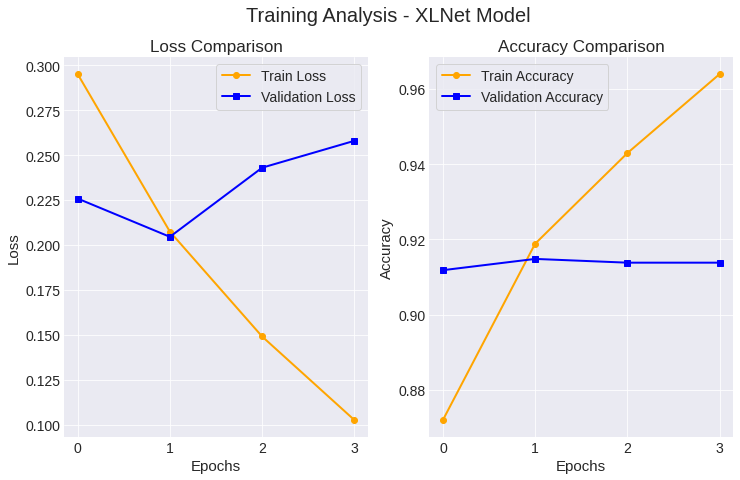

In [15]:
create_plot()